In [38]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, KFold
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.svm import LinearSVR

ImportError: cannot import name 'mean_absolut_error' from 'sklearn.metrics' (C:\Users\Anton\anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

In [7]:
main_df = pd.read_csv('final.csv', sep=',', index_col=0 )

In [8]:
main_df.shape

(91, 172802)

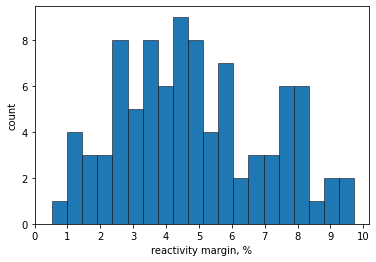

In [9]:
plt.hist(main_df.reactivity_margin, bins=20, linewidth=0.5, edgecolor="black")
plt.xlabel('reactivity margin, %')
plt.ylabel('count')
plt.xticks(list(range(11)))
plt.show()

In [10]:
main_df.drop(columns=['Keff'], inplace=True)

In [11]:
target = main_df.pop('reactivity_margin')

In [43]:
X_train, X_test, y_train, y_test = train_test_split(main_df, target, test_size=0.3, random_state=7)

In [44]:
X_train.shape, X_test.shape

((77, 172800), (14, 172800))

## Sklearn модели

In [14]:
lr = LinearRegression(n_jobs=-1)

sgd = SGDRegressor()

sgd_params = {
    'penalty':['l2', 'elasticnet'],
    'alpha':[0.0001, 0.001, 0.005],
    'l1_ratio':[0.15, 0.25, 0.5, 0.65, 0.75],
    'fit_intercept':[True],
    'tol':[0.0001, 0.0005]
}

svr = LinearSVR()
             
svr_params = {
    'tol':[0.0001, 0.0005],
    'C':[0.1, 0.5, 1, 10]
}


In [32]:
sss = KFold(n_splits=3, shuffle=True, random_state=7)

In [33]:
lr.fit(X_train, y_train)

sgd_search = HalvingGridSearchCV(estimator=sgd, 
                                 param_grid=sgd_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=7).fit(X_train, y_train)

svr_search = HalvingGridSearchCV(estimator=svr, 
                                 param_grid=svr_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=7).fit(X_train, y_train)

In [35]:
lr.predict(X_test)

array([ 8.13298208e+00,  2.92723072e+01,  3.25732094e+00,  4.34013207e+02,
       -1.21193016e+02,  8.13298208e+00,  3.06630256e+02,  2.79389280e+01,
       -1.96779865e+02,  3.06630256e+02, -1.85446788e+02, -6.69256372e+01,
       -9.54112661e+02, -3.45751647e+02,  9.50836701e+00,  1.95141569e+02,
       -4.39386321e+01, -9.19462312e+01,  8.00790799e+00,  2.65836141e+02,
       -1.55203720e+02,  4.93935062e+00,  1.40327629e+02, -1.67891016e+02,
        1.09479291e+02,  8.76664186e+03, -2.11640323e+02,  7.29291336e+02])

In [39]:
mean_absolute_error(y_test, sgd_search.predict(X_test))

1.8312279414821295

In [40]:
mean_absolute_error(y_test, svr_search.predict(X_test))

1.96759557273474

In [50]:
import itertools
dir(itertools)

['__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_grouper',
 '_tee',
 '_tee_dataobject',
 'accumulate',
 'chain',
 'combinations',
 'combinations_with_replacement',
 'compress',
 'count',
 'cycle',
 'dropwhile',
 'filterfalse',
 'groupby',
 'islice',
 'permutations',
 'product',
 'repeat',
 'starmap',
 'takewhile',
 'tee',
 'zip_longest']

In [52]:
help(itertools.islice)

Help on class islice in module itertools:

class islice(builtins.object)
 |  islice(iterable, stop) --> islice object
 |  islice(iterable, start, stop[, step]) --> islice object
 |  
 |  Return an iterator whose next() method returns selected values from an
 |  iterable.  If start is specified, will skip all preceding elements;
 |  otherwise, start defaults to zero.  Step defaults to one.  If
 |  specified as another value, step determines how many values are
 |  skipped between successive calls.  Works like a slice() on a list
 |  but returns an iterator.
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.
 |  
 |  __setstate__(...)
 |      Set state information for unpickling.
 |  
 |  -------------------------------------------------------------

In [41]:
y_test

18    7.877405
22    3.581933
71    5.281506
58    3.631180
37    0.529180
15    8.132982
62    4.417804
43    4.691101
65    2.619540
61    4.417804
13    5.710190
20    4.908618
77    7.768642
12    2.724683
36    3.602376
64    6.669405
11    4.460727
27    8.471011
2     7.808610
17    4.653846
52    4.470769
5     4.933932
26    7.516160
88    2.399032
30    8.246778
90    7.314723
33    1.903080
80    9.071893
Name: reactivity_margin, dtype: float64

In [42]:
y_pred

NameError: name 'y_pred' is not defined

In [62]:
y_pred_2 = sgd.predict(X_test)

In [63]:
mean_squared_error(y_test, y_pred_2)

5.281332872773995